In [1]:
pip install --upgrade gensim

In [2]:
# ML imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ntlk imports
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

# imports for Word2Vec and cosine similarity
from gensim.models import Word2Vec, FastText, KeyedVectors
from scipy.spatial.distance import cosine
import re

# PCA imports
from sklearn.decomposition import PCA

# visualization imports
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from plotnine import *
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Loading in Dataset

In [3]:
og_df = pd.read_csv("Break_Through_AI_Product.csv")
og_df.head()

,Uniq Id,Description,List Price,Sale Price,Brand,Category,Available,Product Name
0,019b67ef7f01103d8fb0a53e4c36daa7,We aim to show you accurate product informati...,31.93,31.93,La Costeï¿½ï¿½a,"Food | Meal Solutions, Grains & Pasta | Canned...",True,"La Costena Chipotle Peppers, 7 OZ (Pack of 12)"
1,3a4ff306dcc8a6e2bf720964d29b84c3,We aim to show you accurate product informati...,10.48,10.48,Equate,Health | Equate | Equate Allergy | Equate Sinu...,True,Equate Triamcinolone Acetonide Nasal Allergy S...
2,80090549d7d176327b186353c7b28ca4,We aim to show you accurate product informati...,10.99,10.99,AduroSmart ERIA,Electronics | Smart Home | Smart Energy and Li...,True,AduroSmart ERIA Soft White Smart A19 Light Bul...
3,151ee1c61a29bacfedb01cd500494b2f,We aim to show you accurate product informati...,38.59,38.59,lowrider,Sports & Outdoors | Bikes | Bike Accessories |...,True,"24"" Classic Adjustable Balloon Fender Set Chro..."
4,7b2ef8d41f65df121f6b4b9828cf8dad,We aim to show you accurate product informati...,5.81,5.81,Anself,Baby | Feeding | Sippy Cups: Alternatives to P...,True,Elephant Shape Silicone Drinkware Portable Sil...


In [4]:
og_df.shape

(30000, 8)

In [5]:
df = pd.read_csv("Break_Through_AI_Product.csv")
df = df.dropna().reset_index(drop=True)

In [6]:
df.dtypes # floats, objects (can use .str to make intro string), and bools

Uniq Id          object
Description      object
List Price      float64
Sale Price      float64
Brand            object
Category         object
Available          bool
Product Name     object
dtype: object

In [7]:
df.describe()
df['Brand'].unique()
df['Brand'].value_counts()

Unique Bargains             317
Generic                     273
Anself                      211
Under Armour                126
lowrider                    110
                           ... 
TUFF STUFF PRODUCTS           1
BlingLights                   1
MAGIC TIME INTERNATIONAL      1
Xyience                       1
Takuminowaza                  1
Name: Brand, Length: 10738, dtype: int64

In [8]:
# the following strips of initial warning at beginning of description columns.
edited_description = df["Description"].str.split("|", n = 1, expand = True)
df["Description"] = edited_description[1]

# Data Preprocessing

### Filtering out all numbers, lowercasing, & removing stopwords (name, description, and brand)

In [9]:
df['Product Name'] = df['Product Name'].replace('[^a-zA-Z/ ]', '', regex=True)
df['Description'] = df['Description'].replace('[^a-zA-Z/ ]', '', regex=True)
df['Brand'] = df['Brand'].replace('[^a-zA-Z/ ]', '', regex=True)

df['Product Name'] = df['Product Name'].str.replace('/', ' ')
df['Description'] = df['Description'].str.replace('/', ' ')
df['Brand'] = df['Brand'].str.replace("/", " ")

In [10]:
df['Product Name'] = df['Product Name'].str.lower()
df['Description'] = df['Description'].str.lower()
df['Brand'] = df['Brand'].str.lower()
df['Category'] = df['Category'].str.lower()

In [11]:
stopword_en = set(nltk.corpus.stopwords.words('english'))
stopword_es = set(nltk.corpus.stopwords.words('spanish'))
stop_words = stopword_en | stopword_es
unique_stops = {'pack', 'oz', 'lbs', 'hr'}
stop_words = stop_words | unique_stops

df['Product Name'] = df['Product Name'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df['Description'] = df['Description'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stop_words]))

### Creating Tokenized Columns

In [12]:
df['Product Tokenized'] = df['Product Name'].str.split()
df['Description Tokenized'] = df['Description'].str.split()
df['Category Tokenized'] = df['Category'].str.split("|")

In [13]:
df.head()

,Uniq Id,Description,List Price,Sale Price,Brand,Category,Available,Product Name,Product Tokenized,Description Tokenized,Category Tokenized
0,019b67ef7f01103d8fb0a53e4c36daa7,costena chipotle peppers easy open ready serve...,31.93,31.93,la costea,"food | meal solutions, grains & pasta | canned...",True,costena chipotle peppers,"[costena, chipotle, peppers]","[costena, chipotle, peppers, easy, open, ready...","[food , meal solutions, grains & pasta , can..."
1,3a4ff306dcc8a6e2bf720964d29b84c3,compare nasacort allergy active ingredient tri...,10.48,10.48,equate,health | equate | equate allergy | equate sinu...,True,equate triamcinolone acetonide nasal allergy s...,"[equate, triamcinolone, acetonide, nasal, alle...","[compare, nasacort, allergy, active, ingredien...","[health , equate , equate allergy , equate ..."
2,80090549d7d176327b186353c7b28ca4,soft white eria bulb k controlled smartphone t...,10.99,10.99,adurosmart eria,electronics | smart home | smart energy and li...,True,adurosmart eria soft white smart light bulb cr...,"[adurosmart, eria, soft, white, smart, light, ...","[soft, white, eria, bulb, k, controlled, smart...","[electronics , smart home , smart energy and..."
3,151ee1c61a29bacfedb01cd500494b2f,lowrider fender set classic adjustable chrome,38.59,38.59,lowrider,sports & outdoors | bikes | bike accessories |...,True,classic adjustable balloon fender set chrome b...,"[classic, adjustable, balloon, fender, set, ch...","[lowrider, fender, set, classic, adjustable, c...","[sports & outdoors , bikes , bike accessorie..."
4,7b2ef8d41f65df121f6b4b9828cf8dad,kind fine quality silicone cup lid unique turn...,5.81,5.81,anself,baby | feeding | sippy cups: alternatives to p...,True,elephant shape silicone drinkware portable sil...,"[elephant, shape, silicone, drinkware, portabl...","[kind, fine, quality, silicone, cup, lid, uniq...","[baby , feeding , sippy cups: alternatives t..."


### Filtering out only unavailable products

In [14]:
df_unavailable = df[df['Available'] == False]
df_unavailable.head()

,Uniq Id,Description,List Price,Sale Price,Brand,Category,Available,Product Name,Product Tokenized,Description Tokenized,Category Tokenized
5,e4fab4b6f41eac02d22b421818c8f080,enojy one favorite tea flavors set twinings se...,17.99,17.99,twinings,food | beverages | tea | all tea,False,boxes twinings london nightly calm green tea b...,"[boxes, twinings, london, nightly, calm, green...","[enojy, one, favorite, tea, flavors, set, twin...","[food , beverages , tea , all tea]"
24,370a181b830e12a28ffed4e0a682f62a,soft delicious nutritious american classic won...,2.58,2.58,wonder,food | fresh food | bakery & bread | bread cru...,False,wonder classic white bread loaf,"[wonder, classic, white, bread, loaf]","[soft, delicious, nutritious, american, classi...","[food , fresh food , bakery & bread , bread..."
44,7ff5f1285c377369e8cc5ea71459f676,product highlights bags per box nongmo gluten ...,13.95,13.95,weight watchers,"food | snacks, cookies & chips | popcorn | pop...",False,weight watchers popcorn white cheddar,"[weight, watchers, popcorn, white, cheddar]","[product, highlights, bags, per, box, nongmo, ...","[food , snacks, cookies & chips , popcorn , ..."
64,728612d29c56965f5d7e675581146ab4,product kelloggs pop tart cherry count granola...,12.56,12.56,product of kelloggs pop tart,food | breakfast & cereal | cold cereal | all ...,False,product kelloggs pop tart cherry count granola...,"[product, kelloggs, pop, tart, cherry, count, ...","[product, kelloggs, pop, tart, cherry, count, ...","[food , breakfast & cereal , cold cereal , ..."
89,6221e8068a72292c67590677c3408e07,adorable aquaticthemed tummy time play mat pil...,42.49,42.49,tiny love,baby | baby activities & gear | gyms & playmats,False,tummy time playmat soft adorable yellow submar...,"[tummy, time, playmat, soft, adorable, yellow,...","[adorable, aquaticthemed, tummy, time, play, m...","[baby , baby activities & gear , gyms & play..."


### Lemmatization


In [15]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# a denotes adjective in "pos"
print("better :", lemmatizer.lemmatize("better", pos ="a"))

df['Description Tokenized'] = df['Description Tokenized'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))
df['Product Tokenized'] = df['Product Tokenized'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))
df['Category Tokenized'] = df['Category Tokenized'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))

[nltk_data] Downloading package wordnet to /root/nltk_data...


better : good


In [16]:
df.head()

,Uniq Id,Description,List Price,Sale Price,Brand,Category,Available,Product Name,Product Tokenized,Description Tokenized,Category Tokenized
0,019b67ef7f01103d8fb0a53e4c36daa7,costena chipotle peppers easy open ready serve...,31.93,31.93,la costea,"food | meal solutions, grains & pasta | canned...",True,costena chipotle peppers,costena chipotle pepper,costena chipotle pepper easy open ready serve ...,"food meal solutions, grains & pasta canned..."
1,3a4ff306dcc8a6e2bf720964d29b84c3,compare nasacort allergy active ingredient tri...,10.48,10.48,equate,health | equate | equate allergy | equate sinu...,True,equate triamcinolone acetonide nasal allergy s...,equate triamcinolone acetonide nasal allergy s...,compare nasacort allergy active ingredient tri...,health equate equate allergy equate sinu...
2,80090549d7d176327b186353c7b28ca4,soft white eria bulb k controlled smartphone t...,10.99,10.99,adurosmart eria,electronics | smart home | smart energy and li...,True,adurosmart eria soft white smart light bulb cr...,adurosmart eria soft white smart light bulb cr...,soft white eria bulb k controlled smartphone t...,electronics smart home smart energy and li...
3,151ee1c61a29bacfedb01cd500494b2f,lowrider fender set classic adjustable chrome,38.59,38.59,lowrider,sports & outdoors | bikes | bike accessories |...,True,classic adjustable balloon fender set chrome b...,classic adjustable balloon fender set chrome b...,lowrider fender set classic adjustable chrome,sports & outdoors bikes bike accessories ...
4,7b2ef8d41f65df121f6b4b9828cf8dad,kind fine quality silicone cup lid unique turn...,5.81,5.81,anself,baby | feeding | sippy cups: alternatives to p...,True,elephant shape silicone drinkware portable sil...,elephant shape silicone drinkware portable sil...,kind fine quality silicone cup lid unique turn...,baby feeding sippy cups: alternatives to p...


In [17]:
corpus_lem = []
for row in df["Product Tokenized"]:
  corpus_lem.append(row)

for row in df["Category Tokenized"]:
  corpus_lem.append(row)

for row in df["Description Tokenized"]:
  corpus_lem.append(row)

for i in range(len(corpus_lem)):
  words = corpus_lem[i].split()
  corpus_lem[i] = words
corpus_lem[0:1]

# Word2Vec model from the corpus
model_lem = Word2Vec(corpus_lem, min_count=1, vector_size = 10)

In [18]:
model_lem.wv.most_similar_cosmul(positive = ['bike', 'helmet'], negative = ['food'])

[('comfortred', 7.542227745056152),
 ('plasic', 6.35736608505249),
 ('seasonstate', 6.067418575286865),
 ('coolerz', 6.018655776977539),
 ('gummiesdietary', 5.793644905090332),
 ('topstitchingeach', 5.636689186096191),
 ('rumble', 5.565805435180664),
 ('lilo', 5.464787483215332),
 ('fingertipoxygen', 5.402196407318115),
 ('packagedincluded', 5.211859703063965)]

# Data Visualization

Text(0.5, 1.0, 'Top 10 Brands')

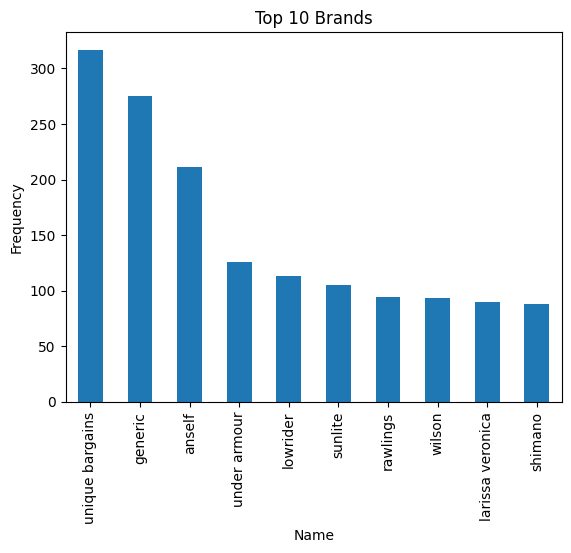

In [19]:
brand_10 = df["Brand"].value_counts()[:10]
brand_10.plot(kind='bar')

plt.xlabel('Name')
plt.ylabel('Frequency')
plt.title('Top 10 Brands')

In [20]:
categories = pd.DataFrame(df['Category Tokenized'])

new_col = list()
for row in categories['Category Tokenized']:
  new_col.append(row.split())
categories["Category List"] = new_col

categories.head()

,Category Tokenized,Category List
0,"food meal solutions, grains & pasta canned...","[food, meal, solutions,, grains, &, pasta, can..."
1,health equate equate allergy equate sinu...,"[health, equate, equate, allergy, equate, sinu..."
2,electronics smart home smart energy and li...,"[electronics, smart, home, smart, energy, and,..."
3,sports & outdoors bikes bike accessories ...,"[sports, &, outdoors, bikes, bike, accessories..."
4,baby feeding sippy cups: alternatives to p...,"[baby, feeding, sippy, cups:, alternatives, to..."


In [21]:
# filter out "&" and extract the second element, being level 2 categories
categories['Category List'] = categories['Category List'].apply(lambda x: [item for item in x if item != '&'])
second_elements = categories['Category List'].apply(lambda x: x[1])

element_counts = Counter(second_elements)

# top 10 most common
top_10_elements = element_counts.most_common(10)
top_10_df = pd.DataFrame(top_10_elements, columns=['Second Element', 'Count'])

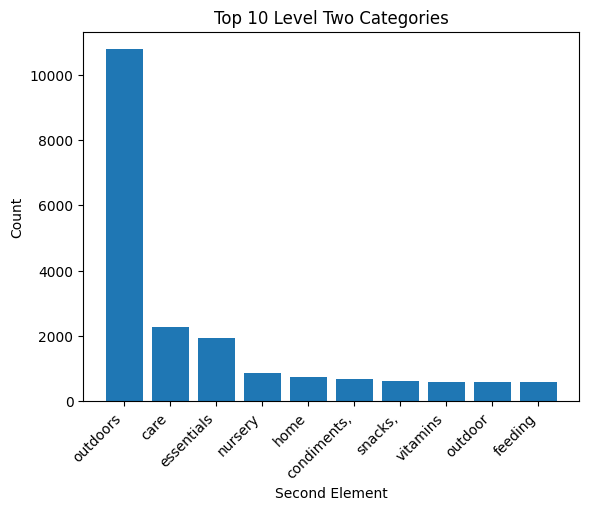

In [22]:
plt.bar(top_10_df['Second Element'], top_10_df['Count'])
plt.xlabel('Second Element')
plt.ylabel('Count')
plt.title('Top 10 Level Two Categories')
plt.xticks(rotation=45, ha='right')
plt.show()

# Category Clustering Prep (W2V)


In [23]:
cat_1 = []
for row in df["Category"]:
  tempList = row.split("|")
  cat_1.append(tempList[0])


df['cat1_w2v'] = cat_1

In [24]:
cat_2 = []

for row in df["Category"]:
  tempList = row.split("|")
  cat_2.append(tempList[0:2])

df['cat2_w2v'] = cat_2

In [25]:
corpus_cat1_w2v = []
for row in df["cat1_w2v"]:
  corpus_cat1_w2v.append(row)

for i in range(len(corpus_cat1_w2v)):
  list1 = corpus_cat1_w2v[i].split()
  list1 = [word for word in list1 if word not in [',', '&', 'to', 'and']] ## removing all the commas and &
  list1 = [word.replace(',', '') for word in list1]

  corpus_cat1_w2v[i] = list1

corpus_cat1_w2v[0:1]

model_cat1_w2v = Word2Vec(corpus_cat1_w2v, min_count=1, vector_size = 10)

In [26]:
model_cat1_w2v.wv.most_similar('food')

[('jewelry', 0.7808261513710022),
 ('toys', 0.4705304205417633),
 ('music', 0.3187551498413086),
 ('clothing', 0.3002755641937256),
 ('household', 0.2250281721353531),
 ('books', 0.15535761415958405),
 ('feature', 0.1499592512845993),
 ('collectibles', 0.13867823779582977),
 ('seasonal', 0.13146406412124634),
 ('sports', 0.052085503935813904)]

In [27]:
corpus_cat2_w2v = []
for row in df["cat2_w2v"]:
  corpus_cat2_w2v.append(row)

for i in range (len(corpus_cat2_w2v)):
  list1 = [corpus_cat2_w2v[i][0]]
  list2 = corpus_cat2_w2v[i][1].split()
  list2 = [word for word in list2 if word not in [',', '&', 'to', 'and']] ## removing all the commas and &
  list2 = [word.replace(',', '') for word in list2]
  list1.extend(list2)
  corpus_cat2_w2v[i] = list1

corpus_cat2_w2v[0:1]

# Word2Vec model for level 2 categories
model_cat2_w2v = Word2Vec(corpus_cat2_w2v, min_count=1, vector_size = 10)

In [28]:
model_cat2_w2v.wv.most_similar('food')

[('cut', 0.9844399690628052),
 ('flowers', 0.9606508016586304),
 ('vinyl', 0.8533941507339478),
 ('music ', 0.8511457443237305),
 ('management', 0.8222669363021851),
 ('rv', 0.7774943709373474),
 ('emergency', 0.7561547756195068),
 ('manual', 0.7510518431663513),
 ('fresh', 0.7475086450576782),
 ('motion', 0.7401245832443237)]

In [29]:
cat_3 = []

for row in df ["Category"]:
  tempList = row.split("|")
  cat_3.append(tempList[0:3])

df['cat3_w2v'] = cat_3

In [30]:
df.head()

,Uniq Id,Description,List Price,Sale Price,Brand,Category,Available,Product Name,Product Tokenized,Description Tokenized,Category Tokenized,cat1_w2v,cat2_w2v,cat3_w2v
0,019b67ef7f01103d8fb0a53e4c36daa7,costena chipotle peppers easy open ready serve...,31.93,31.93,la costea,"food | meal solutions, grains & pasta | canned...",True,costena chipotle peppers,costena chipotle pepper,costena chipotle pepper easy open ready serve ...,"food meal solutions, grains & pasta canned...",food,"[food , meal solutions, grains & pasta ]","[food , meal solutions, grains & pasta , can..."
1,3a4ff306dcc8a6e2bf720964d29b84c3,compare nasacort allergy active ingredient tri...,10.48,10.48,equate,health | equate | equate allergy | equate sinu...,True,equate triamcinolone acetonide nasal allergy s...,equate triamcinolone acetonide nasal allergy s...,compare nasacort allergy active ingredient tri...,health equate equate allergy equate sinu...,health,"[health , equate ]","[health , equate , equate allergy ]"
2,80090549d7d176327b186353c7b28ca4,soft white eria bulb k controlled smartphone t...,10.99,10.99,adurosmart eria,electronics | smart home | smart energy and li...,True,adurosmart eria soft white smart light bulb cr...,adurosmart eria soft white smart light bulb cr...,soft white eria bulb k controlled smartphone t...,electronics smart home smart energy and li...,electronics,"[electronics , smart home ]","[electronics , smart home , smart energy and..."
3,151ee1c61a29bacfedb01cd500494b2f,lowrider fender set classic adjustable chrome,38.59,38.59,lowrider,sports & outdoors | bikes | bike accessories |...,True,classic adjustable balloon fender set chrome b...,classic adjustable balloon fender set chrome b...,lowrider fender set classic adjustable chrome,sports & outdoors bikes bike accessories ...,sports & outdoors,"[sports & outdoors , bikes ]","[sports & outdoors , bikes , bike accessories ]"
4,7b2ef8d41f65df121f6b4b9828cf8dad,kind fine quality silicone cup lid unique turn...,5.81,5.81,anself,baby | feeding | sippy cups: alternatives to p...,True,elephant shape silicone drinkware portable sil...,elephant shape silicone drinkware portable sil...,kind fine quality silicone cup lid unique turn...,baby feeding sippy cups: alternatives to p...,baby,"[baby , feeding ]","[baby , feeding , sippy cups: alternatives t..."


In [31]:
corpus_cat3_w2v = []
for row in df["cat3_w2v"]:
  corpus_cat3_w2v.append(row)

for i in range (len(corpus_cat3_w2v)):
  list1 = corpus_cat3_w2v[i][0].split()
  list1 = [word for word in list1 if word not in [',', '&', 'to', 'and']]
  list1 = [word.replace(',', '') for word in list1]

  list2 = corpus_cat3_w2v[i][1].split()
  list2 = [word for word in list2 if word not in [',', '&', 'to', 'and']]
  list2 = [word.replace(',', '') for word in list2]
  list1.extend(list2)

  if len(corpus_cat3_w2v[i])> 2:
    list3 = corpus_cat3_w2v[i][2].split()
    list3 = [word for word in list3 if word not in [',', '&','to', 'and']]
    list3 = [word.replace(',', '') for word in list3]

    list1.extend(list3)

  corpus_cat3_w2v[i] = list1

corpus_cat3_w2v[10:20]

# Word2Vec model on level 3 categories
model_cat3_w2v = Word2Vec(corpus_cat3_w2v, min_count=1, vector_size = 10)

In [32]:
model_cat3_w2v.wv.most_similar('food')

[('keurig', 0.8780893087387085),
 ('frito-lay', 0.8512366414070129),
 ('bean', 0.8348633646965027),
 ('pink', 0.8241280913352966),
 ('whole', 0.8112972378730774),
 ('bread', 0.8101593852043152),
 ('meat', 0.8060555458068848),
 ('bottled', 0.8039249777793884),
 ('cheese', 0.802983820438385),
 ('fruit', 0.8019443154335022)]

In [33]:
similarity1 = model_cat1_w2v.wv.similarity('outdoors', 'sports')
similarity2 = model_cat2_w2v.wv.similarity('outdoors', 'sports')
similarity3 = model_cat3_w2v.wv.similarity('outdoors', 'sports')

print("cat1",  similarity1)
print("cat2",  similarity2)
print("cat3",  similarity3)

cat1 -0.17975852
cat2 0.6673376
cat3 0.99187917


## Adding Product & Product Description to Category 3


In [34]:
df.head()

,Uniq Id,Description,List Price,Sale Price,Brand,Category,Available,Product Name,Product Tokenized,Description Tokenized,Category Tokenized,cat1_w2v,cat2_w2v,cat3_w2v
0,019b67ef7f01103d8fb0a53e4c36daa7,costena chipotle peppers easy open ready serve...,31.93,31.93,la costea,"food | meal solutions, grains & pasta | canned...",True,costena chipotle peppers,costena chipotle pepper,costena chipotle pepper easy open ready serve ...,"food meal solutions, grains & pasta canned...",food,"[food , meal solutions, grains & pasta ]","[food , meal solutions, grains & pasta , can..."
1,3a4ff306dcc8a6e2bf720964d29b84c3,compare nasacort allergy active ingredient tri...,10.48,10.48,equate,health | equate | equate allergy | equate sinu...,True,equate triamcinolone acetonide nasal allergy s...,equate triamcinolone acetonide nasal allergy s...,compare nasacort allergy active ingredient tri...,health equate equate allergy equate sinu...,health,"[health , equate ]","[health , equate , equate allergy ]"
2,80090549d7d176327b186353c7b28ca4,soft white eria bulb k controlled smartphone t...,10.99,10.99,adurosmart eria,electronics | smart home | smart energy and li...,True,adurosmart eria soft white smart light bulb cr...,adurosmart eria soft white smart light bulb cr...,soft white eria bulb k controlled smartphone t...,electronics smart home smart energy and li...,electronics,"[electronics , smart home ]","[electronics , smart home , smart energy and..."
3,151ee1c61a29bacfedb01cd500494b2f,lowrider fender set classic adjustable chrome,38.59,38.59,lowrider,sports & outdoors | bikes | bike accessories |...,True,classic adjustable balloon fender set chrome b...,classic adjustable balloon fender set chrome b...,lowrider fender set classic adjustable chrome,sports & outdoors bikes bike accessories ...,sports & outdoors,"[sports & outdoors , bikes ]","[sports & outdoors , bikes , bike accessories ]"
4,7b2ef8d41f65df121f6b4b9828cf8dad,kind fine quality silicone cup lid unique turn...,5.81,5.81,anself,baby | feeding | sippy cups: alternatives to p...,True,elephant shape silicone drinkware portable sil...,elephant shape silicone drinkware portable sil...,kind fine quality silicone cup lid unique turn...,baby feeding sippy cups: alternatives to p...,baby,"[baby , feeding ]","[baby , feeding , sippy cups: alternatives t..."


In [35]:
corpus_cat3_w2v [0:10]

[['food', 'meal', 'solutions', 'grains', 'pasta', 'canned', 'goods'],
 ['health', 'equate', 'equate', 'allergy'],
 ['electronics', 'smart', 'home', 'smart', 'energy', 'lighting'],
 ['sports', 'outdoors', 'bikes', 'bike', 'accessories'],
 ['baby', 'feeding', 'sippy', 'cups:', 'alternatives', 'plastic'],
 ['food', 'beverages', 'tea'],
 ['home', 'kids', 'rooms', 'kids', 'storage'],
 ['household', 'essentials', 'bathroom', 'bathroom', 'cleaners'],
 ['food', 'chocolate', 'candy', 'gum', 'mints'],
 ['health', 'diabetes', 'care', 'diabetic', 'socks']]

In [36]:
from csv import list_dialects

corpus_cat3_w2v [0:10]
product_list = []

## adding the product to the corpus with cat 3
for i in range(0,len(df["Product Tokenized"])):
  list_dialects = df["Product Tokenized"][i].split()
  product_list.append(list_dialects)

for i in range(0,len(product_list)):
  for j in range(len(product_list[i])):
    corpus_cat3_w2v[i].append(product_list[i][j])

corpus_cat3_w2v [0:3]

description_list = []
for i in range(0,len(df["Description Tokenized"])):
  list = df["Description Tokenized"][i].split()
  description_list.append(list)

for i in range(0,len(description_list)):
  for j in range(len(description_list[i])):
    corpus_cat3_w2v[i].append(description_list[i][j])

corpus_cat3_w2v [0:3]

model_cat3_w2v = Word2Vec(corpus_cat3_w2v, min_count=1, vector_size = 300)

In [37]:
model_cat3_w2v.wv.most_similar('food')

[('unrelated', 0.5878553986549377),
 ('petseliminates', 0.5183649063110352),
 ('pantry', 0.5174632668495178),
 ('greasing', 0.5150197744369507),
 ('nutritious', 0.5140616297721863),
 ('eating', 0.5038900971412659),
 ('digest', 0.49924343824386597),
 ('leftover', 0.49669188261032104),
 ('parathas', 0.49427205324172974),
 ('preparedness', 0.4935043752193451)]

In [38]:
similarity1 = model_cat1_w2v.wv.similarity('outdoors', 'sports')
similarity2 = model_cat2_w2v.wv.similarity('outdoors', 'sports')
similarity3 = model_cat3_w2v.wv.similarity('outdoors', 'sports')

print("cat1: ",  similarity1)
print("cat2: ",  similarity2)
print("cat3: ",  similarity3)

cat1:  -0.17975852
cat2:  0.6673376
cat3:  0.70192766


# Cosine Similarity

### Creating product vectors

In [39]:
selected_columns = ['Uniq Id', 'Product Tokenized', 'Description Tokenized']
df_products = df[selected_columns]

In [40]:
cat3 = []
for row in df["cat3_w2v"]:
  cat3.append(row)

for i in range (len(cat3)):
  list1 = cat3[i][0].split()
  list1 = [word for word in list1 if word not in [',', '&', 'to', 'and']]
  list1 = [word.replace(',', '') for word in list1]

  list2 = cat3[i][1].split()
  list2 = [word for word in list2 if word not in [',', '&', 'to', 'and']]
  list2 = [word.replace(',', '') for word in list2]
  list1.extend(list2)

  if len(cat3[i])> 2:
    list3 = cat3[i][2].split()
    list3 = [word for word in list3 if word not in [',', '&','to', 'and']]
    list3 = [word.replace(',', '') for word in list3]

    list1.extend(list3)

  cat3[i] = list1

cat3[0]

['food', 'meal', 'solutions', 'grains', 'pasta', 'canned', 'goods']

In [41]:
df_products["cat3"] = cat3
df_products['words'] = df_products['Product Tokenized'] + df_products['Description Tokenized']
df_products.head()

,Uniq Id,Product Tokenized,Description Tokenized,cat3,words
0,019b67ef7f01103d8fb0a53e4c36daa7,costena chipotle pepper,costena chipotle pepper easy open ready serve ...,"[food, meal, solutions, grains, pasta, canned,...",costena chipotle peppercostena chipotle pepper...
1,3a4ff306dcc8a6e2bf720964d29b84c3,equate triamcinolone acetonide nasal allergy s...,compare nasacort allergy active ingredient tri...,"[health, equate, equate, allergy]",equate triamcinolone acetonide nasal allergy s...
2,80090549d7d176327b186353c7b28ca4,adurosmart eria soft white smart light bulb cr...,soft white eria bulb k controlled smartphone t...,"[electronics, smart, home, smart, energy, ligh...",adurosmart eria soft white smart light bulb cr...
3,151ee1c61a29bacfedb01cd500494b2f,classic adjustable balloon fender set chrome b...,lowrider fender set classic adjustable chrome,"[sports, outdoors, bikes, bike, accessories]",classic adjustable balloon fender set chrome b...
4,7b2ef8d41f65df121f6b4b9828cf8dad,elephant shape silicone drinkware portable sil...,kind fine quality silicone cup lid unique turn...,"[baby, feeding, sippy, cups:, alternatives, pl...",elephant shape silicone drinkware portable sil...


In [42]:
df_products['words'] = df_products['words'].apply(lambda x: x.split())
df_products['words'] = df_products['words'] + df_products['cat3']
df_products.head()

,Uniq Id,Product Tokenized,Description Tokenized,cat3,words
0,019b67ef7f01103d8fb0a53e4c36daa7,costena chipotle pepper,costena chipotle pepper easy open ready serve ...,"[food, meal, solutions, grains, pasta, canned,...","[costena, chipotle, peppercostena, chipotle, p..."
1,3a4ff306dcc8a6e2bf720964d29b84c3,equate triamcinolone acetonide nasal allergy s...,compare nasacort allergy active ingredient tri...,"[health, equate, equate, allergy]","[equate, triamcinolone, acetonide, nasal, alle..."
2,80090549d7d176327b186353c7b28ca4,adurosmart eria soft white smart light bulb cr...,soft white eria bulb k controlled smartphone t...,"[electronics, smart, home, smart, energy, ligh...","[adurosmart, eria, soft, white, smart, light, ..."
3,151ee1c61a29bacfedb01cd500494b2f,classic adjustable balloon fender set chrome b...,lowrider fender set classic adjustable chrome,"[sports, outdoors, bikes, bike, accessories]","[classic, adjustable, balloon, fender, set, ch..."
4,7b2ef8d41f65df121f6b4b9828cf8dad,elephant shape silicone drinkware portable sil...,kind fine quality silicone cup lid unique turn...,"[baby, feeding, sippy, cups:, alternatives, pl...","[elephant, shape, silicone, drinkware, portabl..."


### Dimensionality Reduction

In [43]:
from sklearn.preprocessing import StandardScaler
pca = PCA()

vocab = {}
for i, w in enumerate(model_cat3_w2v.wv.key_to_index):
    vocab[w] = model_cat3_w2v.wv.key_to_index[w]

X = model_cat3_w2v.wv[vocab]
X = StandardScaler().fit_transform(X)
pc = pca.fit_transform(X)

pca_df = pd.DataFrame({"expl_var" :
                      pca.explained_variance_ratio_,
                       "pc": "",
                      "cum_var":
                      pca.explained_variance_ratio_.cumsum()})
for i in pca_df:
  pca_df["pc"] = pca_df.index
subset_pca_df = pca_df.iloc[:50]
subset_pca_df.head()

,expl_var,pc,cum_var
0,0.090068,0,0.090068
1,0.082698,1,0.172766
2,0.064268,2,0.237034
3,0.051901,3,0.288935
4,0.046448,4,0.335383


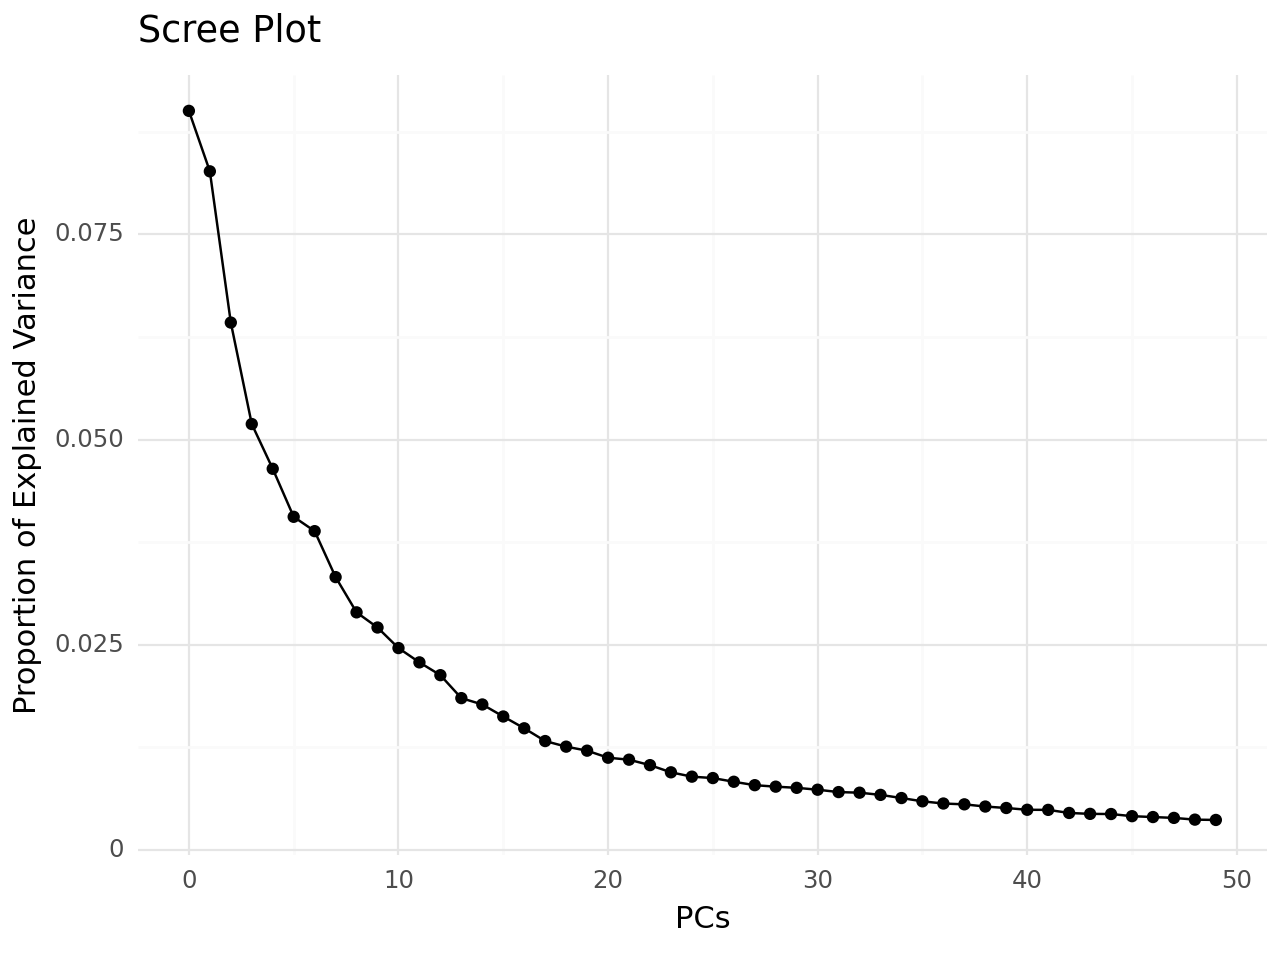

In [44]:
print(ggplot(subset_pca_df, aes(x = "pc", y = "expl_var")) + geom_line() + geom_point() +
 theme_minimal() + labs(x = "PCs", y = "Proportion of Explained Variance", title = "Scree Plot"))

In [45]:
pca = PCA(n_components=10)
word_vectors_pca = pca.fit_transform(X)

In [46]:
vocab_list = model_cat3_w2v.wv.index_to_key
dictionary = {}

for i in range(len(word_vectors_pca)):
  dictionary[vocab_list[i]] = word_vectors_pca[i]

In [47]:
product_vectors = []

for i in range(29367):
  sum = [0]*10
  for j in range(len(df_products["words"][i])):
    if df_products["words"][i][j] in dictionary:
      sum = sum + dictionary[df_products["words"][i][j]]


  ## the average of the vector
  product_vector = sum/len(df_products["words"][0])
  product_vectors.append(product_vector)

In [48]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_matrix = cosine_similarity(product_vectors, product_vectors)
cosine_sim_matrix.shape

(29367, 29367)

In [49]:
# display the cosine similarity matrix
print("Cosine Similarity Matrix:")
print(cosine_sim_matrix)

array = cosine_sim_matrix[3]

## change the value for the product we are inquiring for to 0
array[3] = 0
max_value = max(cosine_sim_matrix[3])
max_index = np.argmax(array)
# print(df.loc[max_index])

Cosine Similarity Matrix:
[[ 1.          0.25665745  0.33992171 ...  0.92196134  0.15808052
   0.29121812]
 [ 0.25665745  1.          0.41093673 ...  0.18826769  0.41016282
   0.3062379 ]
 [ 0.33992171  0.41093673  1.         ...  0.12602626  0.85837749
   0.65996733]
 ...
 [ 0.92196134  0.18826769  0.12602626 ...  1.         -0.05386833
   0.13071237]
 [ 0.15808052  0.41016282  0.85837749 ... -0.05386833  1.
   0.81353048]
 [ 0.29121812  0.3062379   0.65996733 ...  0.13071237  0.81353048
   1.        ]]


In [50]:
og_df = og_df.dropna().reset_index(drop=True)

In [51]:
## given a product name, we want to get its index in the original data frame
product_name_to_find = input("Enter the item you are looking for: ")

# boolean indexing to filter rows with the specified product name
mask = og_df['Product Name'] == product_name_to_find

if all(mask) is False:
  product_index = mask.index[mask].tolist()[0] if mask.any() else None

  if df['Available'][product_index]:
    print()
    print("Your Product is available!")

  else:
    print()
    print("Your Product is unavailable, here is a list of the top 10 most similar products that are available:")
    print()
    ## getting the respective array from the consine_sim_matrix
    array = cosine_sim_matrix[product_index]
    array[product_index] = 0

    available_indices = df[df['Available']].index

    # get the indices of the top 10 maximum values among the available products
    top_available_indices = [index for index in np.argsort(array)[-10:][::-1] if index in available_indices]

    for index in top_available_indices:
      similarity_value = array[index]
      product_name = og_df["Product Name"].iloc[index]
      sale_price = og_df["Sale Price"].iloc[index]
      print(f"Product Name: {product_name}, Price: {sale_price}, Similarity: {similarity_value}")

else:
  print("The product you selected does not exist")

Enter the item you are looking for: Vaseline Lip Therapy Lip Balm Tin Cocoa Butter 0.6 oz

Your Product is unavailable, here is a list of the top 10 most similar products that are available:

Product Name: Vaseline Cocoa Butter Lip Balm Tin, 0.6 oz, Price: 6.55, Similarity: 0.9958257851394403
Product Name: Vaseline Lip Therapy Rosy Lips Holiday Edition 0.6 oz, Price: 5.74, Similarity: 0.994631428824298
Product Name: Carmex Classic Medicated Lip Balm, SPF 15, 3 ea (Pack of 6), Price: 24.04, Similarity: 0.9925561063708118
Product Name: Carmex Classic Medicated Lip Balm, SPF 15, 3 ea (Pack of 3), Price: 13.51, Similarity: 0.9925561063708118
Product Name: 3 Pack Vaseline Creme Brulee for Deliciously, Kissable Lips, 0.25oz Each, Price: 7.73, Similarity: 0.9918053262133715
Product Name: Vaseline Lip Therapy Aloe Vera | Lip Balm with Petroleum Jelly for providing your Lips with Ultimate Hydration and Essential Moisture to treat Chapped, Dry, Peeling, or Cracked Lips; 0.16 Oz (3 Pack), Price: 